In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
import matplotlib as mpl
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np
from math import erf, sqrt
import scipy.stats as st
from scipy.stats import chi2, gamma
from scipy.special import erfcinv
from scipy.linalg import sqrtm


import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

chi2_val = chi2.ppf(0.6827, df=2)

d = 2
L = 3  # Number of vectors
n_samples = int(1e6)

Path to git repo: /home/matias/Documents/PhD/code


# PTE to $N_{\sigma}$

What is $N_{\sigma}^{eff}$? Let's do some plots

In [2]:
from math import sqrt
from scipy.stats import chi2
from math import erf


def L_iso_from_n(d: int, n: float, sigma2: float = 0.5, gauss_scale: str = '1sigma') -> float:
    """
    Compute the Euclidean separation L between the means of two identical,
    isotropic D-dimensional Gaussian distributions with covariance
    Σ = sigma2 * I. The distance is defined such that the corresponding
    probability mass that lies within ±nσ in 1D becomes tangential
    (i.e. the confidence regions just "touch").

    Parameters
    ----------
    d : int
        Dimensionality of the parameter space.
    n : float
        "Number of 1D sigmas" associated with the probability p = erf(n / sqrt(2)).
    sigma2 : float, optional
        Isotropic variance per dimension (default: 0.5).
    gauss_scale : {"1sigma", "2sigma"}, optional
        Interpretation of n in terms of 1D or 2D Gaussian probability content.

    Returns
    -------
    float
        Euclidean distance L between the two mean vectors.
    """

    scale = gauss_scale.lower()
    if scale == '1sigma':
        # 1D probability associated with ±nσ
        p = erf(n / sqrt(2.0))
    elif scale == '2sigma':
        # 2D probability via chi-square distribution with df=2
        p = chi2.cdf(n**2, df=2)
    else:
        raise ValueError("gauss_scale must be either '1sigma' or '2sigma'.")

    # Corresponding chi-square percentile with d degrees of freedom: m^2 = χ²_{d,p}
    m2 = chi2.ppf(p, df=d)
    m = sqrt(m2)

    # Isotropic case: L = 2 * σ * m with σ = sqrt(sigma2)
    return 2.0 * sqrt(sigma2) * m


# Example usage
if __name__ == "__main__":
    print('--- Using 1sigma scale ---')
    for n_ in [1, 2, 3, 4, 5]:
        print(n_, L_iso_from_n(d=2, n=n_))   # d=2, sigma^2=0.5

    print('--- Using 2sigma scale ---')
    for n_ in [1, 2, 3, 4, 5]:
        print(n_, L_iso_from_n(d=2, n=n_, gauss_scale='2sigma'))   # d=2, sigma^2=0.5


--- Using 1sigma scale ---
1 2.142778070122352
2 3.515700301858557
3 4.863981513513553
4 6.21834521588094
5 7.5820448992254725
--- Using 2sigma scale ---
1 1.4142135623730951
2 2.8284271247461903
3 4.242640687119287
4 5.656854249492375
5 7.071067811867373


In [3]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM


def construct_C(vectors):
    L = len(vectors)

    K_xx = np.sum((vectors[:, 0]) ** 2)
    K_yy = np.sum((vectors[:, 1]) ** 2)
    K_xy = np.sum((vectors[:, 0]) * (vectors[:, 1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C

def analyzed_lambdas(vectors):
    L = len(vectors)
    C = construct_C(vectors)
    lambdas = np.linalg.eigvals(C)
    mean_lambda = np.sum(lambdas)/L
    std_lambda = np.std(lambdas)
    return mean_lambda, std_lambda

def PTE_2_l(PTE):
    aux = gamma(d,1).isf(PTE) #(beta/L)*
    #l = 2*aux
    l = np.sqrt(aux)
    return l

In [4]:
def Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, L, H0=False):
    cov_1 = cov_A + cov_B
    cov_2 = cov_A + cov_C
    cov_3 = cov_B + cov_C

    DA = np.random.multivariate_normal(mean_A, cov_A, size=n_samples)
    DB = np.random.multivariate_normal(mean_B, cov_B, size=n_samples)
    DC = np.random.multivariate_normal(mean_C, cov_C, size=n_samples)
    
    # Sampling
    sample_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), np.array(DA-DB).T)  # Shape: (d, n_samples)
    sample_2 = np.dot(sqrtm(np.linalg.inv(cov_2)), np.array(DA-DC).T)  # Shape: (d, n_samples)
    sample_3 = np.dot(sqrtm(np.linalg.inv(cov_3)), np.array(DB-DC).T)  # Shape: (d, n_samples)
    
    if H0==True:
        sample_1_H0 = sample_1 - np.mean(sample_1, axis=1, keepdims=True)
        sample_2_H0 = sample_2 - np.mean(sample_2, axis=1, keepdims=True)
        sample_3_H0 = sample_3 - np.mean(sample_3, axis=1, keepdims=True)
        
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1_H0[:,i])**2 + np.linalg.norm(sample_2_H0[:,i])**2 + np.linalg.norm(sample_3_H0[:,i])**2       
    else:
        Q = np.zeros(n_samples)
        for i in range(n_samples):
            Q[i] = np.linalg.norm(sample_1[:,i])**2 + np.linalg.norm(sample_2[:,i])**2 + np.linalg.norm(sample_3[:,i])**2

    return Q / L

# Synthetic case 1

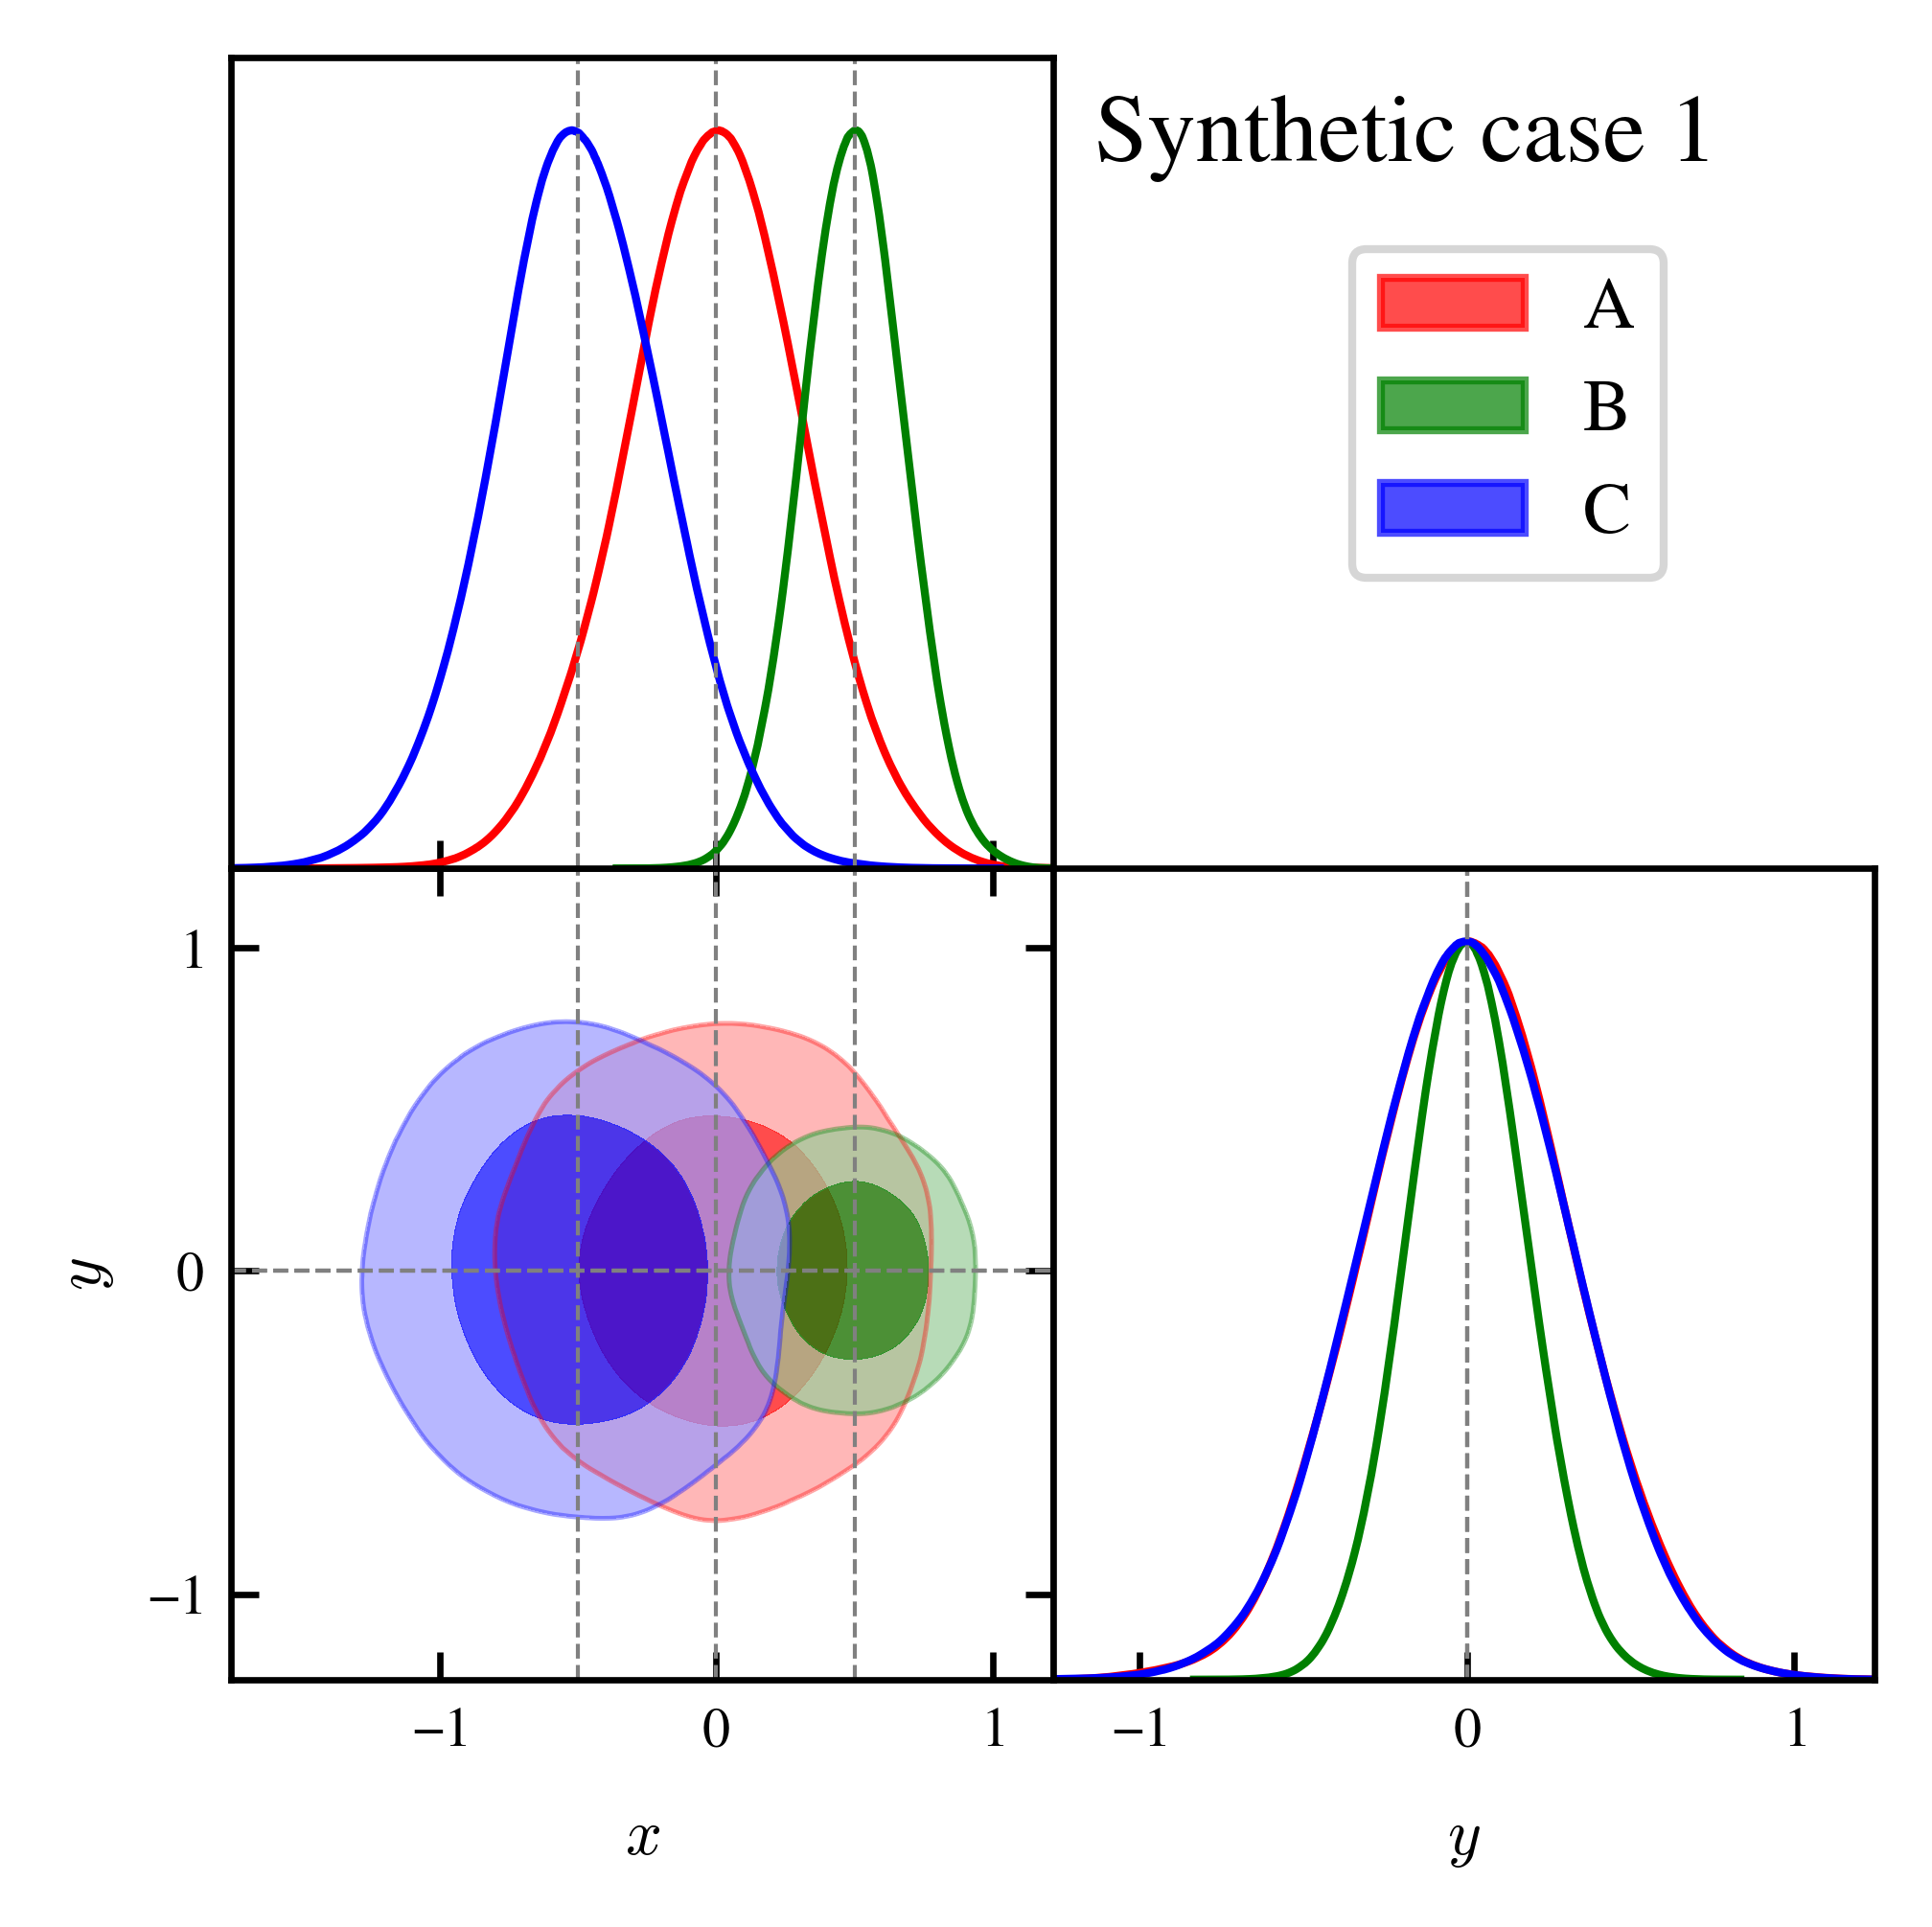

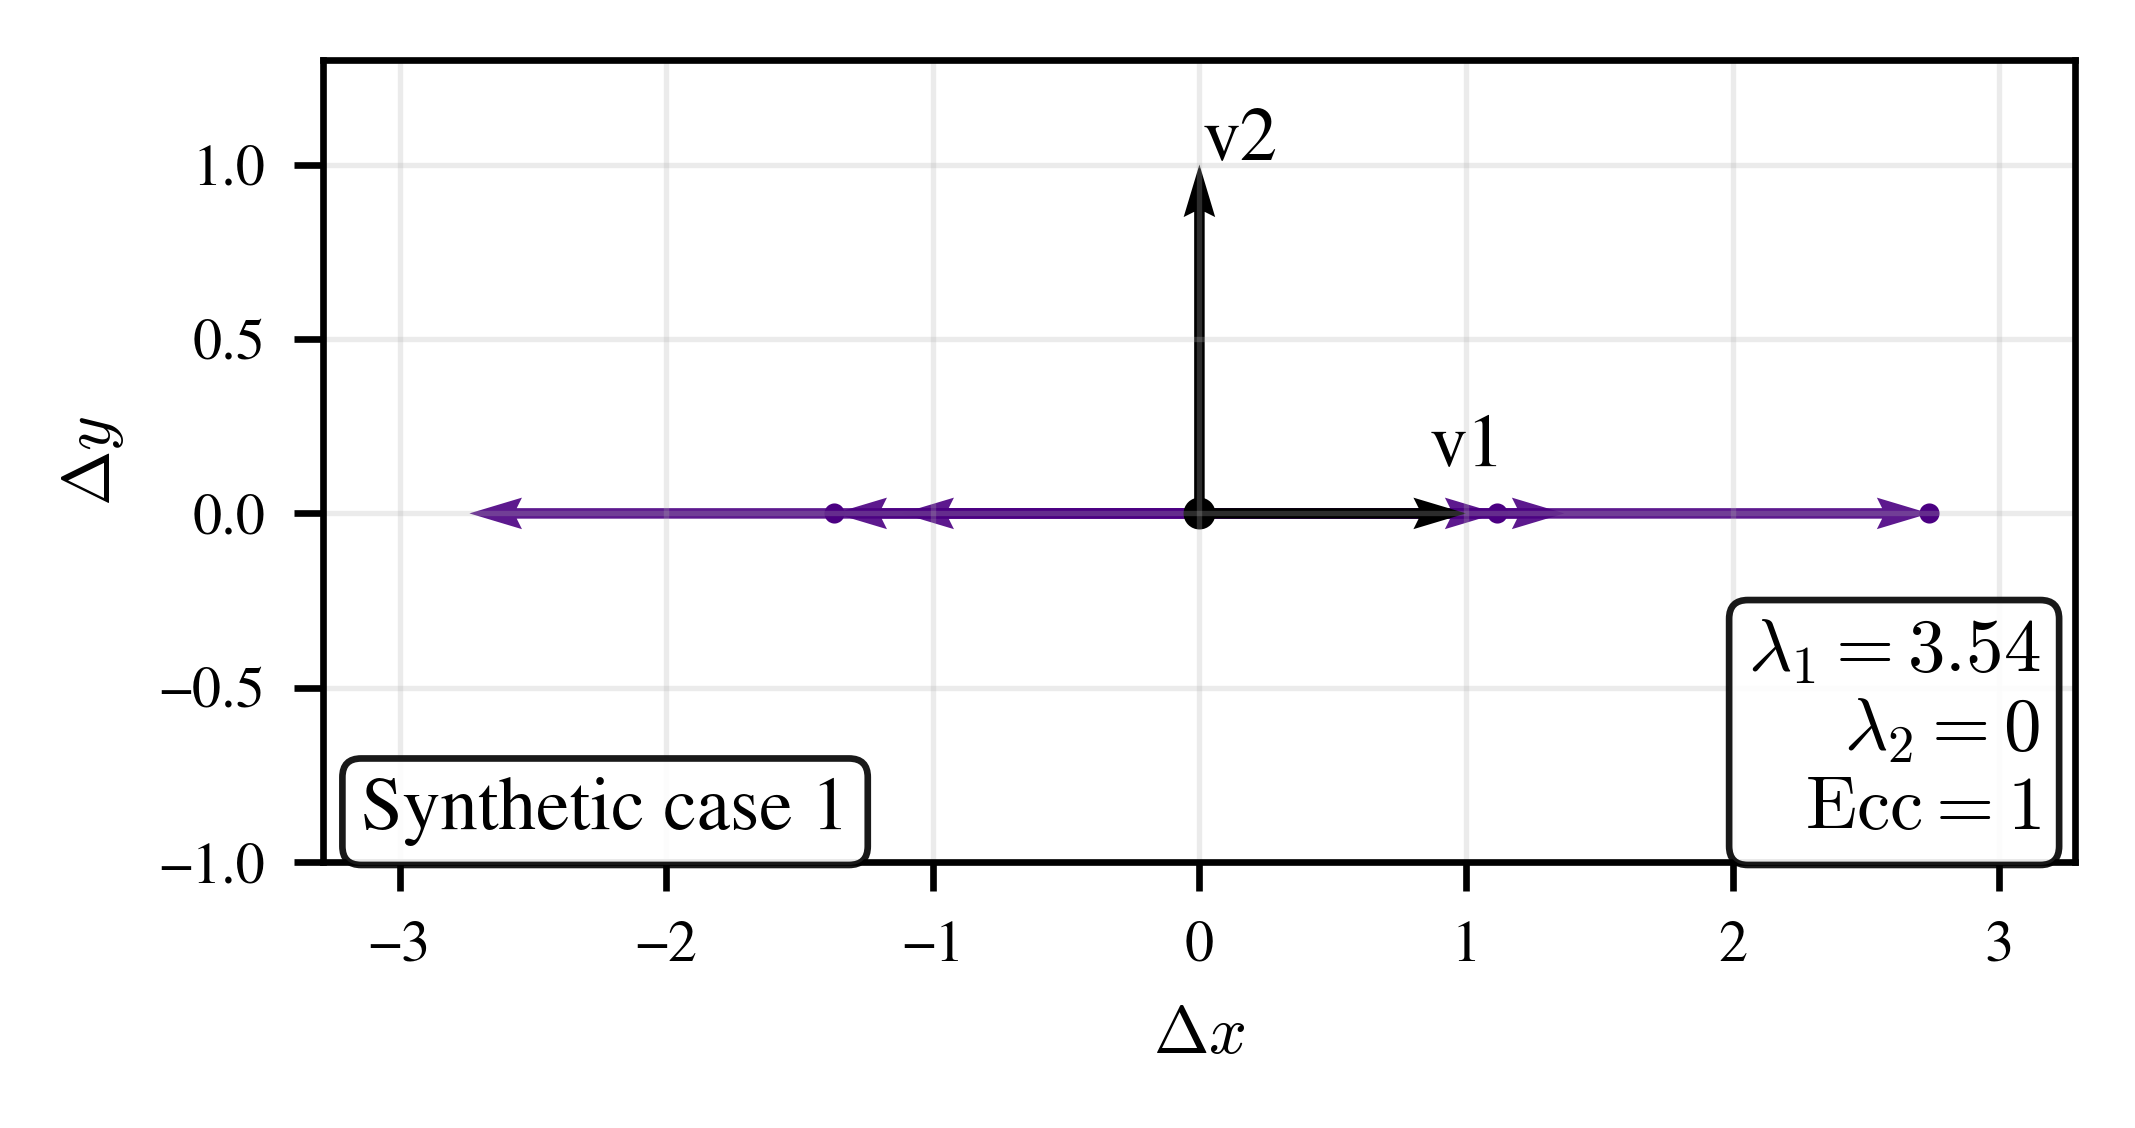

In [5]:
# ----------------------------------------------------------------------
# Synthetic means and covariances
# ----------------------------------------------------------------------
mean_C = np.array([-1/2., 0.])
mean_B = np.array([ 1/2., 0.])
mean_A = np.array([ 0.  , 0.])

cov_C = 0.1 * np.eye(d)
cov_B = cov_C.copy() / 3.0
cov_A = cov_C.copy()

title = 'Case 2'
name_plot = 'synth_1'
analytic_tension = False
eff_dist = True
png = False
x_lim = None
y_lim = [-1, 1.3]

# ----------------------------------------------------------------------
# Global font family and math options
# ----------------------------------------------------------------------
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Nimbus Roman", "Times New Roman", "DejaVu Serif", "TeXGyreTermes"],
    "mathtext.fontset": "cm",   # math symbols similar to Computer Modern
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ----------------------------------------------------------------------
# Plot layout constants (single-column figure)
# ----------------------------------------------------------------------
COLUMN_WIDTH_IN = 3.37  # inches ~ 8.6 cm
SIZE_LABEL = 8
SIZE_TICK  = 7
SIZE_LEG   = 9
LW         = 0.8   # line width
QUIVER_W   = 0.006 # arrow width (in inches, approx.)

# Local style configuration (used via rc_context)
rc = {
    "font.size": SIZE_TICK,
    "axes.titlesize": SIZE_LABEL,
    "axes.labelsize": SIZE_LABEL,
    "xtick.labelsize": SIZE_TICK,
    "ytick.labelsize": SIZE_TICK,
    "legend.fontsize": SIZE_LEG,
    "lines.linewidth": LW,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Nimbus Roman", "Times New Roman", "DejaVu Serif"],
}

names  = ['x', 'y']
labels = ['x', 'y']

# ----------------------------------------------------------------------
# Tension vectors r_k
# ----------------------------------------------------------------------
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = -r_1
r_5 = -r_2
r_6 = -r_3
R = np.vstack([r_1, r_2, r_3, r_4, r_5, r_6])

# ----------------------------------------------------------------------
# Total covariance C_tot and eigensystem
# ----------------------------------------------------------------------
C_tot = construct_C(R)
evals, evecs = np.linalg.eigh(C_tot)
idx = np.argsort(evals)[::-1]
lam1, lam2 = evals[idx[0]], evals[idx[1]]
v1 = evecs[:, idx[0]]
v2 = evecs[:, idx[1]]

# ----------------------------------------------------------------------
# Tension metrics / PTE
# ----------------------------------------------------------------------
beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2) / 3.0

if not analytic_tension:
    Q_H0 = Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, 3, H0=True)
    PTE  = (Q_H0 > beta_L).sum() / Q_H0.size
else:
    PTE  = gamma(d, 1).sf(beta_L)

n_sigma = np.sqrt(2) * erfcinv(PTE)

# ----------------------------------------------------------------------
# Samples for GetDist triangle plot
# ----------------------------------------------------------------------
samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

dark_violet = '#4B0082'
# High-contrast RGB-like colors
colors_tri = ['#ff0000', '#008000', '#0000ff']

# ----------------------------------------------------------------------
# Triangle plot (GetDist), exported at target width
# ----------------------------------------------------------------------
with mpl.rc_context(rc):
    # In GetDist 1.6.1 we control the final width via width_inch
    g = plots.get_subplot_plotter(width_inch=COLUMN_WIDTH_IN, scaling=False)
    g.settings.axes_fontsize   = SIZE_TICK
    g.settings.axes_labelsize  = SIZE_LABEL
    g.settings.legend_fontsize = SIZE_LEG

    g.triangle_plot(
        [chain_A, chain_B, chain_C],
        filled=True,
        contour_args={'alpha': 0.7},
        contour_colors=colors_tri,
        legend_labels=['A', 'B', 'C'],
        legend_loc=[0.7, 0.7]
    )

    g.add_param_markers({
        'x': [mean_A[0], mean_B[0], mean_C[0]],
        'y': [mean_A[1], mean_B[1], mean_C[1]],
    })
    g.add_text('Synthetic case 1', 0.05, 1.9)

    g.export(f'figures/dist_synth_{name_plot}.png')
    g.export(f'figures/dist_synth_{name_plot}.pdf')
    g.export(f'figures/dist_synth_{name_plot}.svg')

# ----------------------------------------------------------------------
# Geometric figure in the space of tension vectors
# ----------------------------------------------------------------------
with mpl.rc_context(rc):
    # Height chosen for a compact single-column plot
    fig_w, fig_h = COLUMN_WIDTH_IN, COLUMN_WIDTH_IN / 2.0

    fig, ax = plt.subplots(1, 1, figsize=(fig_w, fig_h))

    ax.set_xlabel(r'$\Delta x$')
    ax.set_ylabel(r'$\Delta y$')

    # Draw tension vectors
    for r in (r_1, r_2, r_3, r_4, r_5, r_6):
        ax.quiver(
            0, 0, r[0], r[1],
            angles='xy', scale_units='xy', scale=1,
            color=dark_violet, width=QUIVER_W, alpha=0.9
        )

    # Endpoints of the three "primary" tension vectors + origin
    ax.scatter(
        [r_1[0], r_2[0], r_3[0]],
        [r_1[1], r_2[1], r_3[1]],
        marker='.', color=dark_violet, s=8
    )
    ax.scatter([0], [0], color='black', s=8)

    # Eigenvectors (unit vectors)
    ax.quiver(0, 0, v1[0], v1[1],
              angles='xy', scale_units='xy', scale=1,
              color='black', width=QUIVER_W)
    ax.quiver(0, 0, v2[0], v2[1],
              angles='xy', scale_units='xy', scale=1,
              color='black', width=QUIVER_W)

    # Labels for v1 and v2 with a small offset
    max_range = np.max(np.abs(R)) if np.isfinite(R).all() else 1.0
    offset = 0.005 * max_range

    sx = 1 if v1[0] >= 0 else -1
    sy = 1 if v1[1] >= 0 else -1
    ax.text(
        v1[0] - 10 * sx * offset,
        v1[1] + 10 * sy * offset,
        'v1', size=SIZE_LEG, color='black'
    )

    sx = 1 if v2[0] >= 0 else -1
    sy = 1 if v2[1] >= 0 else -1
    ax.text(
        v2[0] + sx * offset,
        v2[1] + sy * offset,
        'v2', size=SIZE_LEG, color='black'
    )

    # ------------------------------------------------------------------
    # Small box with eigenvalues and eccentricity
    # ------------------------------------------------------------------
    lam_min = float(np.min(evals))
    lam_max = float(np.max(evals))

    # Protect against numerical issues when lam_max ~ 0
    ecc = np.sqrt(max(0.0, 1.0 - (lam_min / lam_max if lam_max > 0 else 0.0)))

    info_text = (
        rf"$\lambda_1 = {lam1:.3g}$" "\n"
        rf"$\lambda_2 = {lam2:.3g}$" "\n"
        rf"$\mathrm{{Ecc}} = {ecc:.3g}$"
    )

    ax.text(
        0.98, 0.02, info_text,
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=SIZE_LEG,
        bbox=dict(
            boxstyle='round,pad=0.25',
            facecolor='white',
            alpha=0.9,
            edgecolor='black',
            linewidth=LW
        )
    )

    ax.text(
        0.3, 0.02, 'Synthetic case 1',
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=SIZE_LEG,
        bbox=dict(
            boxstyle='round,pad=0.25',
            facecolor='white',
            alpha=0.9,
            edgecolor='black',
            linewidth=LW
        )
    )

    # ------------------------------------------------------------------
    # Automatic anisotropic limits with padding
    # ------------------------------------------------------------------
    Rx = np.abs(R[:, 0])
    Ry = np.abs(R[:, 1])

    max_x = float(np.nanmax(Rx)) if np.all(np.isfinite(Rx)) else 0.0
    max_y = float(np.nanmax(Ry)) if np.all(np.isfinite(Ry)) else 0.0

    if max_x < 1e-6:
        max_x = 1.0
    if max_y < 1e-6:
        max_y = 1.0

    pad_x = 0.20 * max_x
    pad_y = 0.20 * max_y

    auto_x = (-max_x - pad_x, max_x + pad_x)
    auto_y = (-max_y - pad_y, max_y + pad_y)

    lim_x = x_lim if x_lim is not None else auto_x
    lim_y = y_lim if y_lim is not None else auto_y

    ax.set_xlim(*lim_x)
    ax.set_ylim(*lim_y)

    # Keep approximate aspect ratio of the data (optional)
    dx = abs(lim_x[1] - lim_x[0])
    dy = abs(lim_y[1] - lim_y[0])
    if dx < 1e-12:
        dx = 1.0
    if dy < 1e-12:
        dy = 1.0
    # ax.set_aspect(dx / dy)

    ax.grid(True, alpha=0.25, linewidth=LW * 0.8)

    fig.tight_layout(pad=0.02)

    # Save in the figures subfolder (adapt path_global as needed)
    os.chdir(os.path.join(path_global, 'multimeter', 'notebooks', 'paper_plots'))
    fig.savefig(f'figures/geom_{name_plot}_beta.png', dpi=300, bbox_inches='tight')
    fig.savefig(f'figures/geom_{name_plot}.pdf',               bbox_inches='tight')
    fig.savefig(f'figures/geom_{name_plot}.svg',               bbox_inches='tight')

    plt.show()

# Synthetic case 2

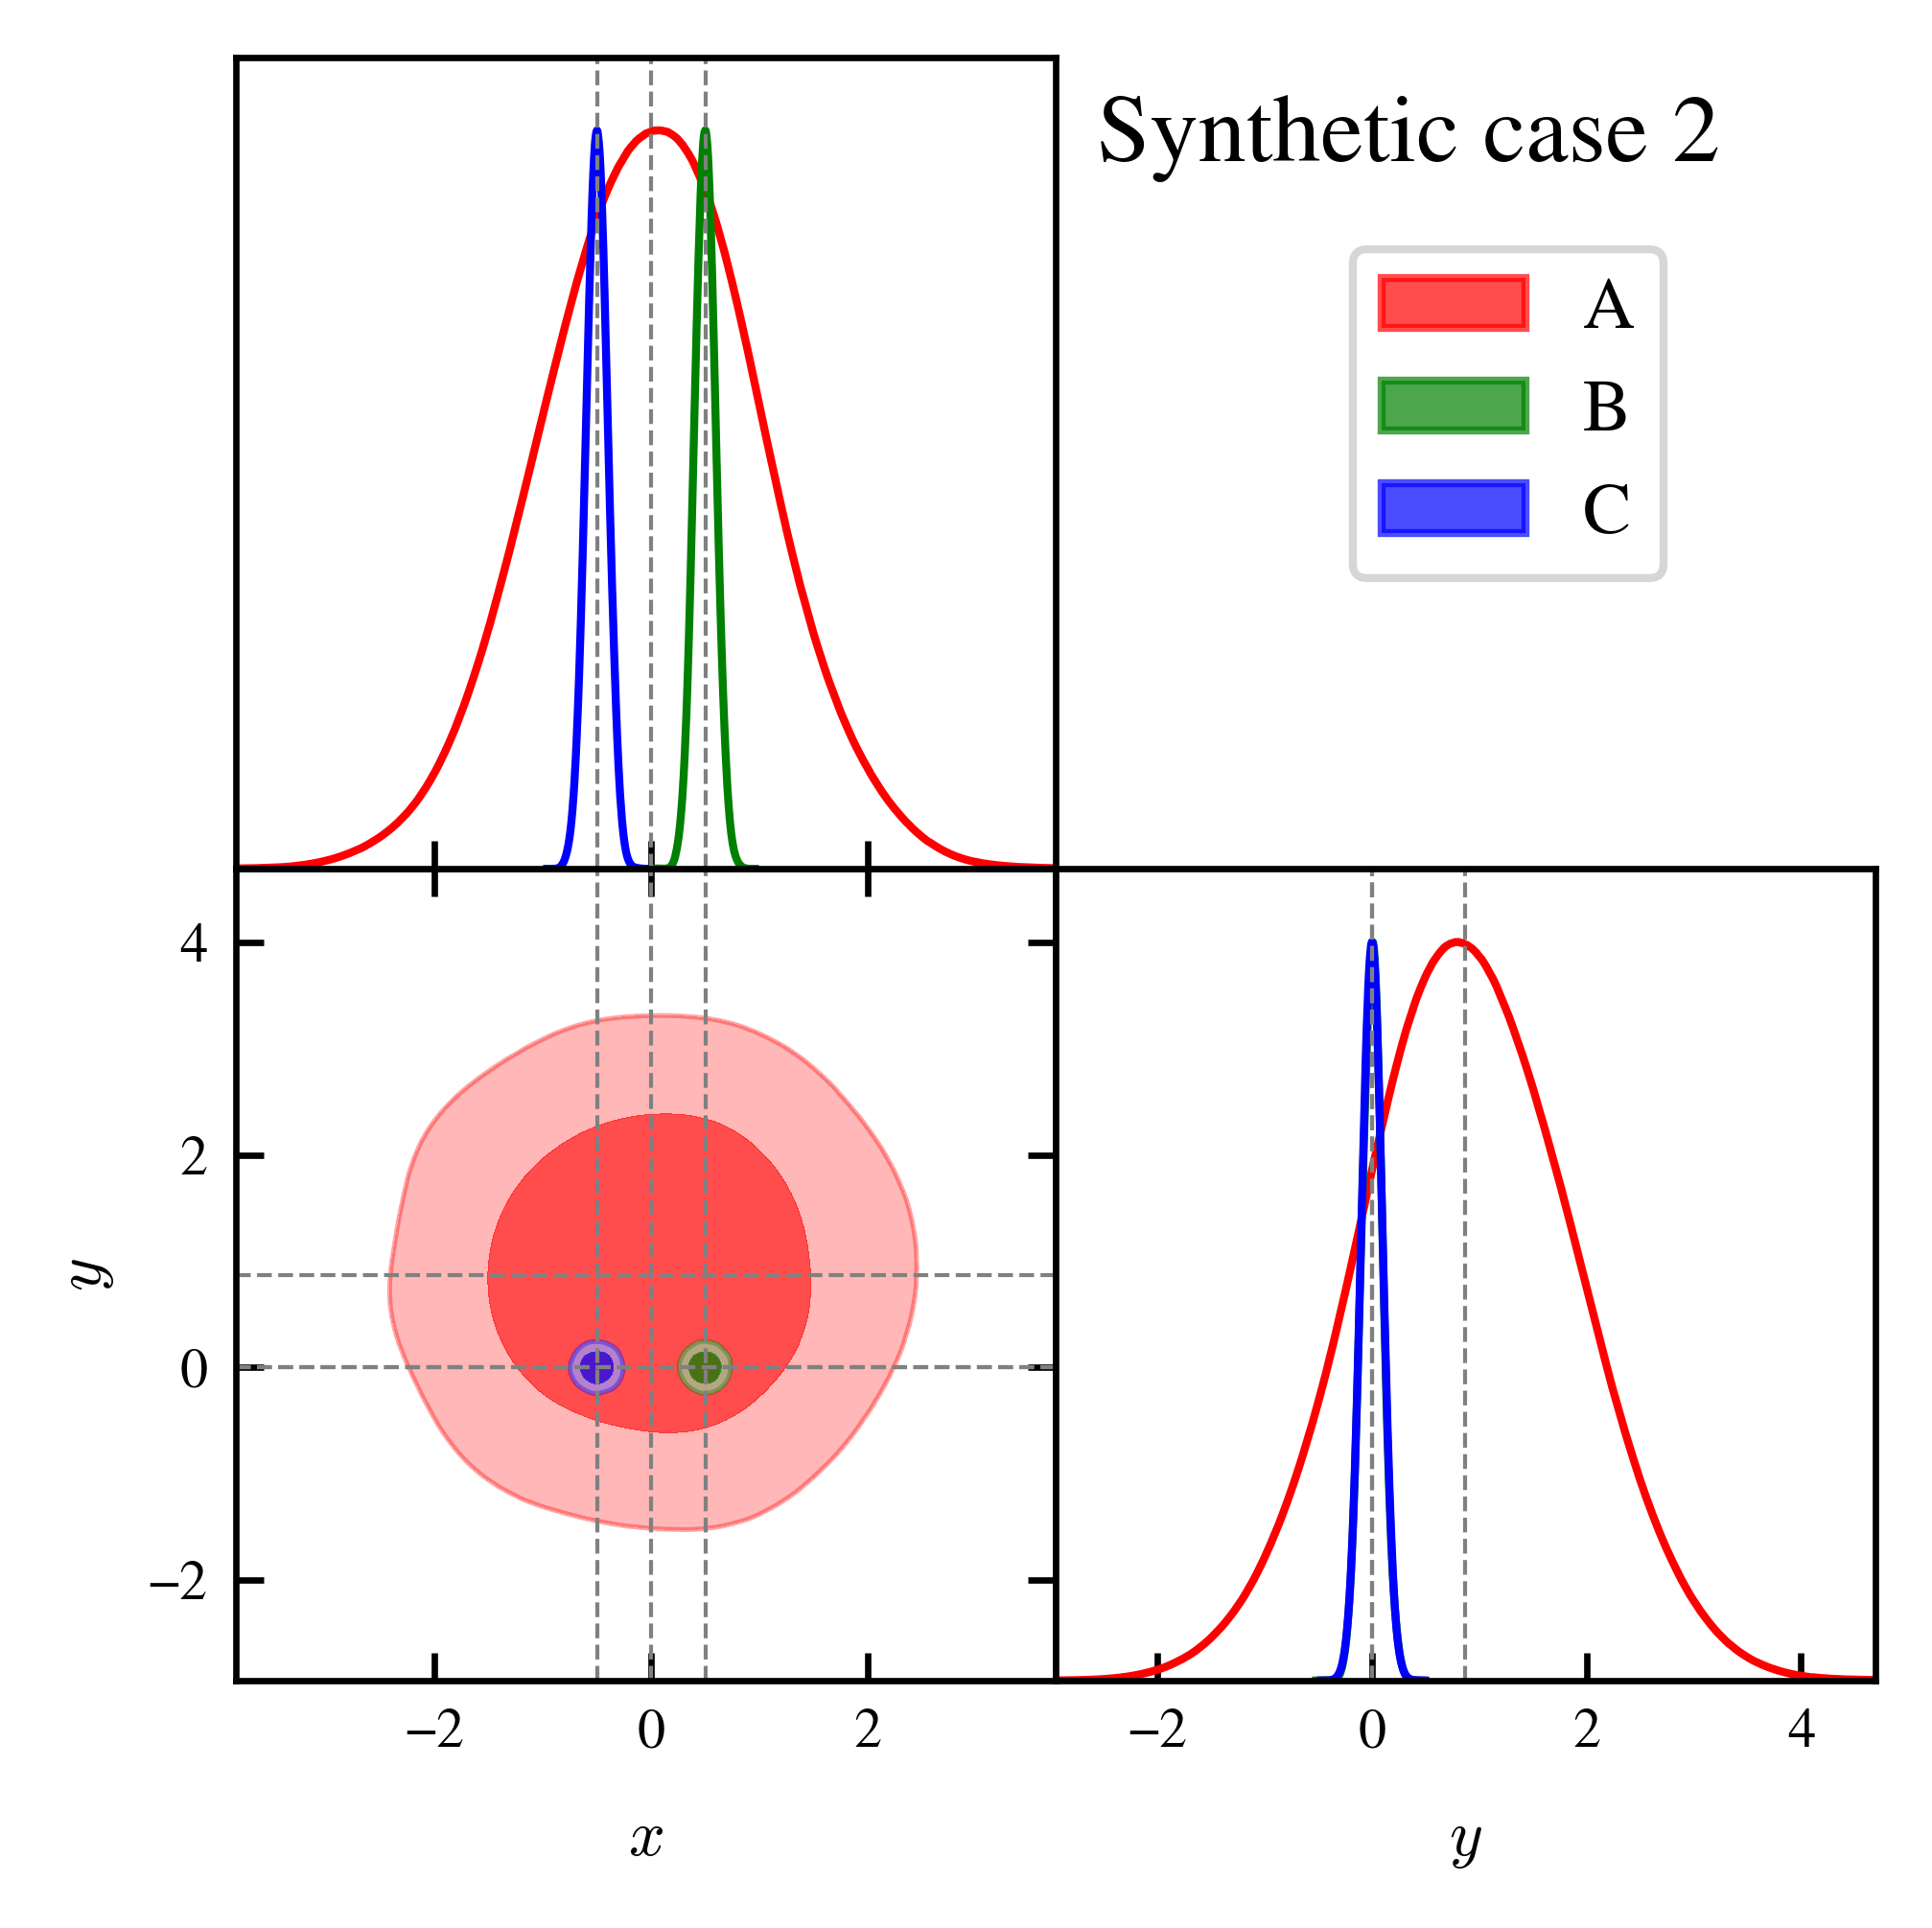

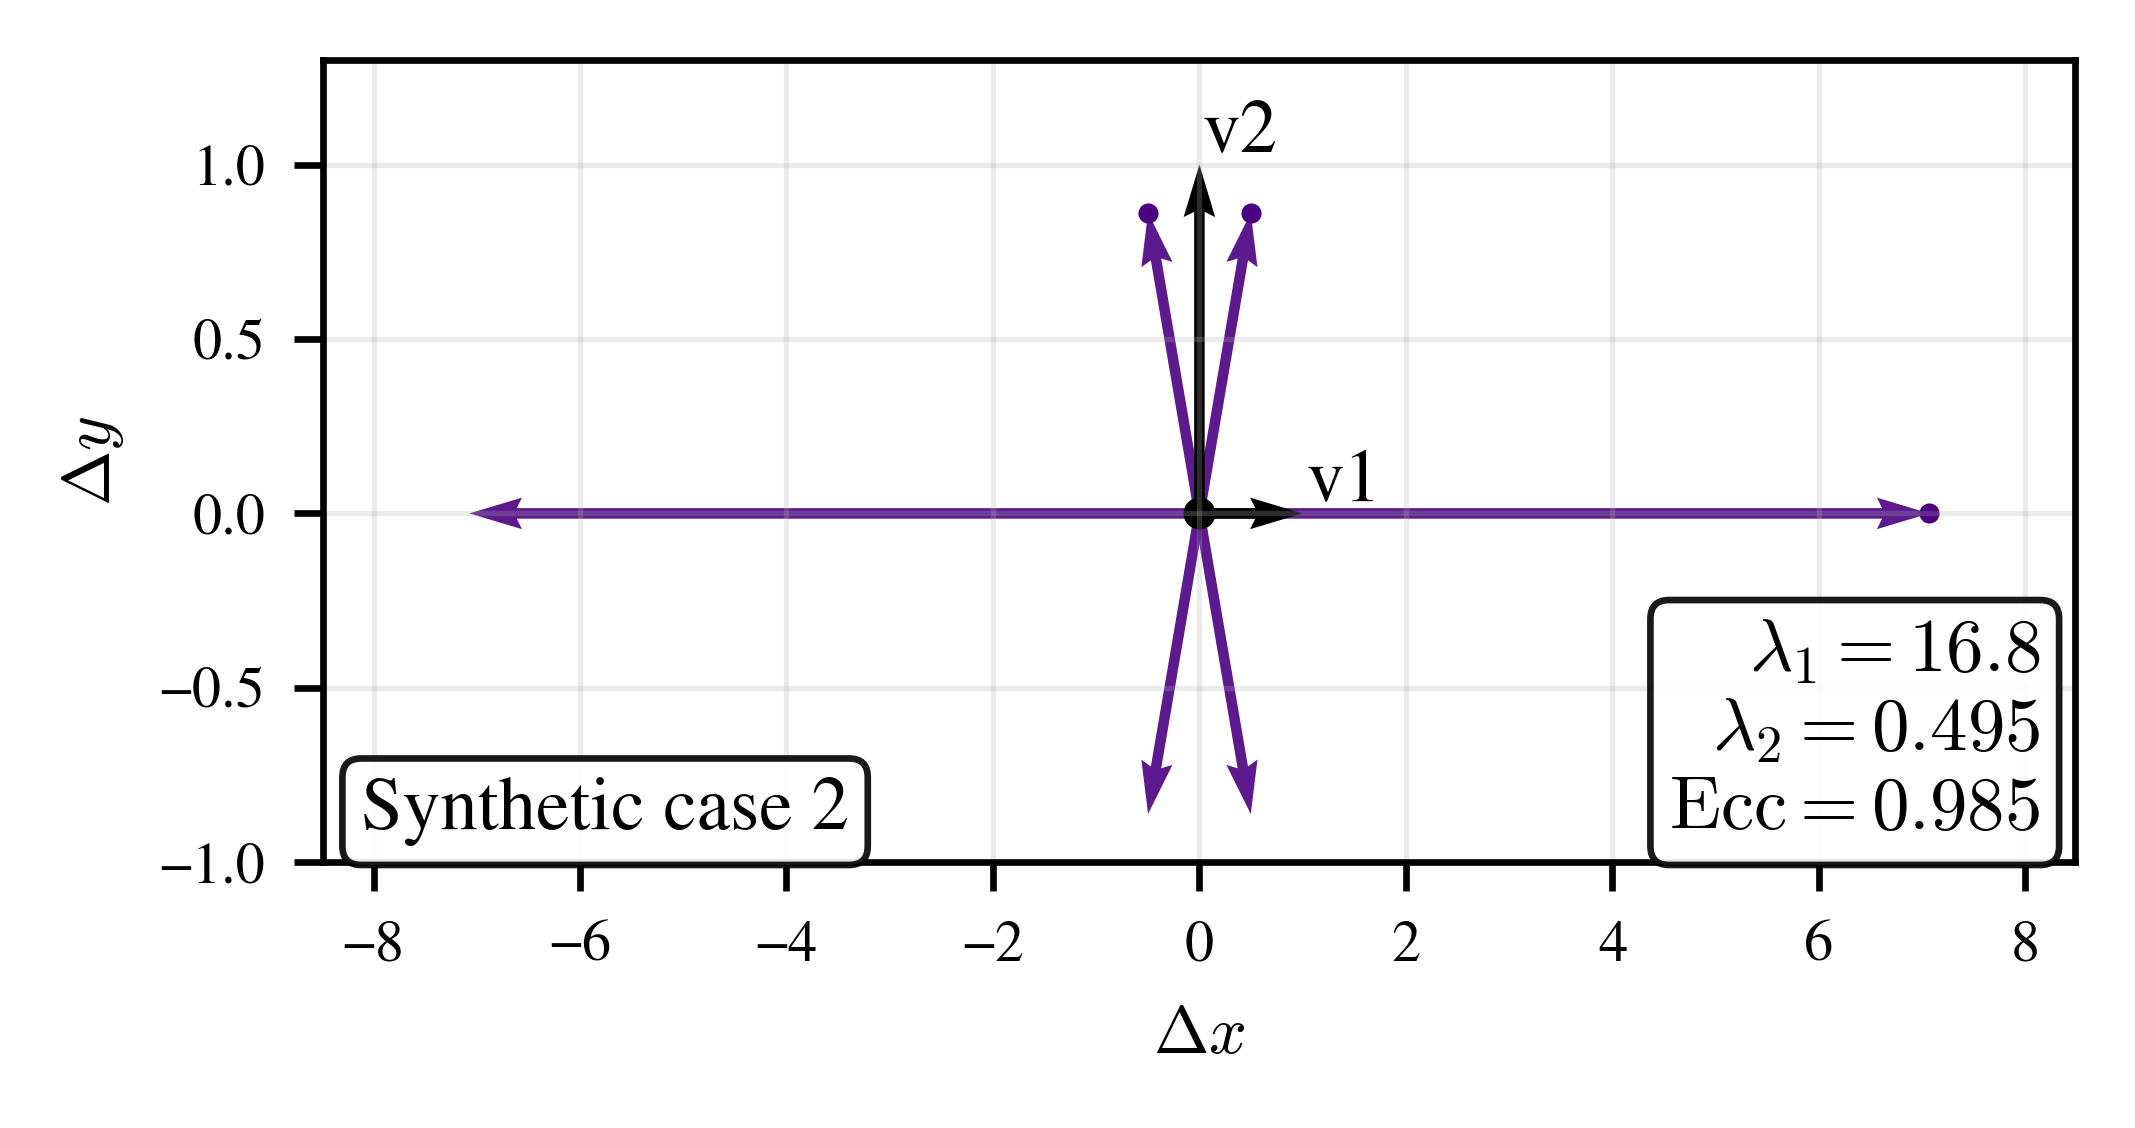

In [6]:
# ----------------------------------------------------------------------
# Synthetic means and covariances (case 4)
# ----------------------------------------------------------------------
mean_C = np.array([-1/2., 0.])
mean_B = np.array([ 1/2., 0.])
mean_A = np.array([ 0.  , np.sqrt(3) / 2.])

cov_C = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_C.copy()
cov_A = 100.0 * cov_C.copy()

title = 'Case 4'
name_plot = 'synth_2'
analytic_tension = False
eff_dist = True
png = False
x_lim = None
y_lim = [-1, 1.3]

# ----------------------------------------------------------------------
# Global font family and math options
# ----------------------------------------------------------------------
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Nimbus Roman", "Times New Roman", "DejaVu Serif", "TeXGyreTermes"],
    "mathtext.fontset": "cm",   # math symbols similar to Computer Modern
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ----------------------------------------------------------------------
# Plot layout constants (single-column figure)
# ----------------------------------------------------------------------
COLUMN_WIDTH_IN = 3.37  # inches ~ 8.6 cm
SIZE_LABEL = 8
SIZE_TICK  = 7
SIZE_LEG   = 9
LW         = 0.8   # line width
QUIVER_W   = 0.006 # arrow width (in inches, approx.)

# Local style configuration (used via rc_context)
rc = {
    "font.size": SIZE_TICK,
    "axes.titlesize": SIZE_LABEL,
    "axes.labelsize": SIZE_LABEL,
    "xtick.labelsize": SIZE_TICK,
    "ytick.labelsize": SIZE_TICK,
    "legend.fontsize": SIZE_LEG,
    "lines.linewidth": LW,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Nimbus Roman", "Times New Roman", "DejaVu Serif"],
}

names  = ['x', 'y']
labels = ['x', 'y']

# ----------------------------------------------------------------------
# Tension vectors r_k
# ----------------------------------------------------------------------
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = -r_1
r_5 = -r_2
r_6 = -r_3
R = np.vstack([r_1, r_2, r_3, r_4, r_5, r_6])

# ----------------------------------------------------------------------
# Total covariance C_tot and eigensystem
# ----------------------------------------------------------------------
C_tot = construct_C(R)
evals, evecs = np.linalg.eigh(C_tot)
idx = np.argsort(evals)[::-1]
lam1, lam2 = evals[idx[0]], evals[idx[1]]
v1 = evecs[:, idx[0]]
v2 = evecs[:, idx[1]]

# ----------------------------------------------------------------------
# Tension metrics / PTE
# ----------------------------------------------------------------------
beta_L = (np.linalg.norm(r_1)**2 + np.linalg.norm(r_2)**2 + np.linalg.norm(r_3)**2) / 3.0

if not analytic_tension:
    Q_H0 = Q_tot_quad(mean_A, mean_B, mean_C, cov_A, cov_B, cov_C, n_samples, 3, H0=True)
    PTE  = (Q_H0 > beta_L).sum() / Q_H0.size
else:
    PTE  = gamma(d, 1).sf(beta_L)

n_sigma = np.sqrt(2) * erfcinv(PTE)

# ----------------------------------------------------------------------
# Samples for GetDist triangle plot
# ----------------------------------------------------------------------
samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')

dark_violet = '#4B0082'
# High-contrast RGB-like colors
colors_tri = ['#ff0000', '#008000', '#0000ff']

# ----------------------------------------------------------------------
# Triangle plot (GetDist), exported at target width
# ----------------------------------------------------------------------
with mpl.rc_context(rc):
    g = plots.get_subplot_plotter(width_inch=COLUMN_WIDTH_IN, scaling=False)
    g.settings.axes_fontsize   = SIZE_TICK
    g.settings.axes_labelsize  = SIZE_LABEL
    g.settings.legend_fontsize = SIZE_LEG

    g.triangle_plot(
        [chain_A, chain_B, chain_C],
        filled=True,
        contour_args={'alpha': 0.7},
        contour_colors=colors_tri,
        legend_labels=['A', 'B', 'C'],
        legend_loc=[0.7, 0.7]
    )

    g.add_param_markers({
        'x': [mean_A[0], mean_B[0], mean_C[0]],
        'y': [mean_A[1], mean_B[1], mean_C[1]],
    })
    g.add_text('Synthetic case 2', 0.05, 1.9)

    g.export(f'figures/dist_synth_{name_plot}.png')
    g.export(f'figures/dist_synth_{name_plot}.pdf')
    g.export(f'figures/dist_synth_{name_plot}.svg')

# ----------------------------------------------------------------------
# Geometric figure in the space of tension vectors
# ----------------------------------------------------------------------
with mpl.rc_context(rc):
    # Height chosen for a compact single-column plot
    fig_w, fig_h = COLUMN_WIDTH_IN, COLUMN_WIDTH_IN / 2.0

    fig, ax = plt.subplots(1, 1, figsize=(fig_w, fig_h))

    ax.set_xlabel(r'$\Delta x$')
    ax.set_ylabel(r'$\Delta y$')

    # Draw tension vectors
    for r in (r_1, r_2, r_3, r_4, r_5, r_6):
        ax.quiver(
            0, 0, r[0], r[1],
            angles='xy', scale_units='xy', scale=1,
            color=dark_violet, width=QUIVER_W, alpha=0.9
        )

    # Endpoints of the three "primary" tension vectors + origin
    ax.scatter(
        [r_1[0], r_2[0], r_3[0]],
        [r_1[1], r_2[1], r_3[1]],
        marker='.', color=dark_violet, s=8
    )
    ax.scatter([0], [0], color='black', s=8)

    # Eigenvectors (unit vectors)
    ax.quiver(0, 0, v1[0], v1[1],
              angles='xy', scale_units='xy', scale=1,
              color='black', width=QUIVER_W)
    ax.quiver(0, 0, v2[0], v2[1],
              angles='xy', scale_units='xy', scale=1,
              color='black', width=QUIVER_W)

    # Label eigenvectors with a small offset
    max_range = np.max(np.abs(R)) if np.isfinite(R).all() else 1.0
    offset = 0.005 * max_range

    def label_at_vector(ax_, r, text, off, color='black'):
        sx = 1 if r[0] >= 0 else -1
        sy = 1 if r[1] >= 0 else -1
        ax_.text(r[0] + sx * off, r[1] + sy * off, text, size=SIZE_LEG, color=color)

    label_at_vector(ax, v1, 'v1', offset, color='black')
    label_at_vector(ax, v2, 'v2', offset, color='black')

    # ------------------------------------------------------------------
    # Small box with eigenvalues and eccentricity
    # ------------------------------------------------------------------
    lam_min = float(np.min(evals))
    lam_max = float(np.max(evals))

    # Protect against numerical issues when lam_max ~ 0
    ecc = np.sqrt(max(0.0, 1.0 - (lam_min / lam_max if lam_max > 0 else 0.0)))

    info_text = (
        rf"$\lambda_1 = {lam1:.3g}$" "\n"
        rf"$\lambda_2 = {lam2:.3g}$" "\n"
        rf"$\mathrm{{Ecc}} = {ecc:.3g}$"
    )

    ax.text(
        0.98, 0.02, info_text,
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=SIZE_LEG,
        bbox=dict(
            boxstyle='round,pad=0.25',
            facecolor='white',
            alpha=0.9,
            edgecolor='black',
            linewidth=LW
        )
    )

    ax.text(
        0.3, 0.02, 'Synthetic case 2',
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=SIZE_LEG,
        bbox=dict(
            boxstyle='round,pad=0.25',
            facecolor='white',
            alpha=0.9,
            edgecolor='black',
            linewidth=LW
        )
    )

    # ------------------------------------------------------------------
    # Automatic anisotropic limits with padding
    # ------------------------------------------------------------------
    Rx = np.abs(R[:, 0])
    Ry = np.abs(R[:, 1])

    max_x = float(np.nanmax(Rx)) if np.all(np.isfinite(Rx)) else 0.0
    max_y = float(np.nanmax(Ry)) if np.all(np.isfinite(Ry)) else 0.0

    if max_x < 1e-6:
        max_x = 1.0
    if max_y < 1e-6:
        max_y = 1.0

    pad_x = 0.20 * max_x
    pad_y = 0.20 * max_y

    auto_x = (-max_x - pad_x, max_x + pad_x)
    auto_y = (-max_y - pad_y, max_y + pad_y)

    lim_x = x_lim if x_lim is not None else auto_x
    lim_y = y_lim if y_lim is not None else auto_y

    ax.set_xlim(*lim_x)
    ax.set_ylim(*lim_y)
    ax.grid(True, alpha=0.25, linewidth=LW * 0.8)

    fig.tight_layout(pad=0.02)

    # Save in the figures subfolder (adapt path_global as needed)
    os.chdir(os.path.join(path_global, 'multimeter', 'notebooks', 'paper_plots'))
    fig.savefig(f'figures/geom_{name_plot}_beta.png', dpi=300, bbox_inches='tight')
    fig.savefig(f'figures/geom_{name_plot}.pdf',               bbox_inches='tight')
    fig.savefig(f'figures/geom_{name_plot}.svg',               bbox_inches='tight')

    plt.show()
